In [97]:
from pymongo import MongoClient
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql.types import *
from pyspark.sql import functions as F
from pyspark import SparkContext
from datetime import datetime
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
from matplotlib import cbook, cm
from matplotlib.colors import LightSource

In [98]:
# Connect to MongoDB
client = MongoClient('mongodb://mongodb:27017/')
db = client.Youtube_Database
collection = db.youtube_data_us

# Print the first document
print(collection.find_one())

# Close the connection
client.close()

{'_id': ObjectId('6771509f1fb74dc5de3f2a04'), 'video_id': '3C66w5Z0ixs', 'title': 'I ASKED HER TO BE MY GIRLFRIEND...', 'publishedAt': '2020-08-11T19:20:14Z', 'channelId': 'UCvtRTOMP2TqYqu51xNrqAzg', 'channelTitle': 'Brawadis', 'categoryId': 22, 'trending_date': '2020-08-12T00:00:00Z', 'tags': 'brawadis|prank|basketball|skits|ghost|funny videos|vlog|vlogging|NBA|browadis|challenges|bmw i8|faze rug|faze rug brother|mama rug and papa rug', 'view_count': 1514614, 'likes': 156908, 'dislikes': 5855, 'comment_count': 35313, 'thumbnail_link': 'https://i.ytimg.com/vi/3C66w5Z0ixs/default.jpg', 'comments_disabled': False, 'ratings_disabled': False, 'description': 'SUBSCRIBE to BRAWADIS ▶ http://bit.ly/SubscribeToBrawadis\r\rFOLLOW ME ON SOCIAL\r▶ Twitter: https://twitter.com/Brawadis\r▶ Instagram: https://www.instagram.com/brawadis/\r▶ Snapchat: brawadis\r\rHi! I’m Brandon Awadis and I like to make dope vlogs, pranks, reactions, challenges and basketball videos. Don’t forget to subscribe and com

## Spark

In [99]:
spark_ = SparkSession.builder \
    .appName("company_database") \
    .config("spark.mongodb.input.uri", "mongodb://mongodb:27017/Company_Database") \
    .config("spark.mongodb.output.uri", "mongodb://mongodb:27017/Company_Database") \
    .config("spark.mongodb.input.uri", "mongodb://mongodb:27017/Youtube_Database") \
    .config("spark.mongodb.output.uri", "mongodb://mongodb:27017/Youtube_Database") \
    .config("spark.jars.packages", "org.mongodb.spark:mongo-spark-connector_2.12:3.0.1") \
    .config("spark.driver.memory", "6g") \
    .config("spark.executor.memory", "6g") \
    .getOrCreate()

## Importanção dos dados de cada pais

In [100]:
df_us = spark_.read.format("mongo").option("uri", "mongodb://mongodb:27017/Youtube_Database.youtube_data_us").load()
df_br = spark_.read.format("mongo").option("uri", "mongodb://mongodb:27017/Youtube_Database.youtube_data_br").load()
df_ca = spark_.read.format("mongo").option("uri", "mongodb://mongodb:27017/Youtube_Database.youtube_data_ca").load()
df_fr = spark_.read.format("mongo").option("uri", "mongodb://mongodb:27017/Youtube_Database.youtube_data_fr").load()
df_gb = spark_.read.format("mongo").option("uri", "mongodb://mongodb:27017/Youtube_Database.youtube_data_gb").load()
df_in = spark_.read.format("mongo").option("uri", "mongodb://mongodb:27017/Youtube_Database.youtube_data_in").load()
df_kr = spark_.read.format("mongo").option("uri", "mongodb://mongodb:27017/Youtube_Database.youtube_data_kr").load()
df_mx = spark_.read.format("mongo").option("uri", "mongodb://mongodb:27017/Youtube_Database.youtube_data_mx").load()

## Importanção dos dados de empresa

In [101]:
df_dell = spark_.read.format("mongo").option("uri", "mongodb://mongodb:27017/Company_Database.dell_data").load()
df_ibm = spark_.read.format("mongo").option("uri", "mongodb://mongodb:27017/Company_Database.ibm_data").load()
df_intel = spark_.read.format("mongo").option("uri", "mongodb://mongodb:27017/Company_Database.intel_data").load()
df_microsoft = spark_.read.format("mongo").option("uri", "mongodb://mongodb:27017/Company_Database.microsoft_data").load()
df_nvidia = spark_.read.format("mongo").option("uri", "mongodb://mongodb:27017/Company_Database.nvidia_data").load()
df_sony = spark_.read.format("mongo").option("uri", "mongodb://mongodb:27017/Company_Database.sony_data").load()

## Dicionario das empresas e seus nomes para posteriormente fazer a união dos dfs com a coluna company_name

In [102]:
dict_companies = {'companies': [
                 {'dataframe':df_dell, 'name': 'dell'},
                 {'dataframe':df_ibm, 'name': 'ibm'},
                 {'dataframe':df_intel, 'name': 'intel'},
                 {'dataframe':df_microsoft, 'name': 'microsoft'},
                 {'dataframe':df_nvidia, 'name': 'nvidia'},
                 {'dataframe':df_sony, 'name': 'sony'},  
                ]
            }

In [103]:
for company in dict_companies['companies']:
    company["dataframe"] = company["dataframe"].withColumn("company_name", lit(company["name"]))

In [104]:
df_companies = dict_companies['companies'][0]['dataframe'].union(dict_companies['companies'][1]['dataframe']).union(dict_companies['companies'][2]['dataframe']).union(dict_companies['companies'][3]['dataframe']).union(dict_companies['companies'][4]['dataframe']).union(dict_companies['companies'][5]['dataframe'])

In [105]:
df_us.printSchema()

root
 |-- _id: struct (nullable = true)
 |    |-- oid: string (nullable = true)
 |-- categoryId: integer (nullable = true)
 |-- channelId: string (nullable = true)
 |-- channelTitle: string (nullable = true)
 |-- comment_count: integer (nullable = true)
 |-- comments_disabled: boolean (nullable = true)
 |-- description: string (nullable = true)
 |-- dislikes: integer (nullable = true)
 |-- likes: integer (nullable = true)
 |-- publishedAt: string (nullable = true)
 |-- ratings_disabled: boolean (nullable = true)
 |-- tags: string (nullable = true)
 |-- thumbnail_link: string (nullable = true)
 |-- title: string (nullable = true)
 |-- trending_date: string (nullable = true)
 |-- video_id: string (nullable = true)
 |-- view_count: integer (nullable = true)



In [106]:
# Filtrar os videos por país relacionados a uma empresa

companies = ['nvidia', 'dell', 'ibm', 'intel', 'microsoft', 'sony']
countries_df = [df_us, df_br, df_ca, df_fr, df_gb, df_in, df_kr, df_mx]
countries = ['us', 'br', 'ca', 'fr', 'gb', 'in', 'kr', 'mx']

yt = {company: {} for company in companies}

def filter_df(df, company):
    filtered_df = df.filter(
        (col('title').contains(company.upper())) |
        (col('channelTitle').contains(company.upper()))
    )
    return filtered_df.withColumn("company", lit(company))

for company in companies:
    for country, country_df in zip(countries, countries_df):
        filtered_data = filter_df(country_df, company)
        yt[company].setdefault(country, []).append(filtered_data)
        

## União dos df de cada pais num só

In [107]:
from functools import reduce

# Extract all DataFrames from the yt dictionary
all_dfs = [
    df 
    for company, country_data in yt.items() 
    for country, dfs in country_data.items() 
    for df in dfs
]

# Union all DataFrames using reduce
if all_dfs:
    df_yt = reduce(lambda df1, df2: df1.union(df2), all_dfs)
else:
    df_yt = None  # Handle case where there are no DataFrames

# Result: `df_yt` is the union of all DataFrames

In [108]:
df_yt.count()

1302

## Colunas existentes

In [109]:
df_yt.printSchema()

root
 |-- _id: struct (nullable = true)
 |    |-- oid: string (nullable = true)
 |-- categoryId: integer (nullable = true)
 |-- channelId: string (nullable = true)
 |-- channelTitle: string (nullable = true)
 |-- comment_count: integer (nullable = true)
 |-- comments_disabled: boolean (nullable = true)
 |-- description: string (nullable = true)
 |-- dislikes: integer (nullable = true)
 |-- likes: integer (nullable = true)
 |-- publishedAt: string (nullable = true)
 |-- ratings_disabled: boolean (nullable = true)
 |-- tags: string (nullable = true)
 |-- thumbnail_link: string (nullable = true)
 |-- title: string (nullable = true)
 |-- trending_date: string (nullable = true)
 |-- video_id: string (nullable = true)
 |-- view_count: integer (nullable = true)
 |-- company: string (nullable = false)



In [110]:
df_companies.count()

57226

## União dos videos de cada empresa

df_yt_companies - todos os videos das empresas a serem estudadas<br> 
df_all_companies - dados de todas as empreas a serem estudadas

## Estudo dos nulos

In [111]:
# YT
df_yt.select([count(when(col(c).isNull(), c)).alias(c) for c in df_yt.columns]).show()

+---+----------+---------+------------+-------------+-----------------+-----------+--------+-----+-----------+----------------+----+--------------+-----+-------------+--------+----------+-------+
|_id|categoryId|channelId|channelTitle|comment_count|comments_disabled|description|dislikes|likes|publishedAt|ratings_disabled|tags|thumbnail_link|title|trending_date|video_id|view_count|company|
+---+----------+---------+------------+-------------+-----------------+-----------+--------+-----+-----------+----------------+----+--------------+-----+-------------+--------+----------+-------+
|  0|         0|        0|           0|            0|                0|          0|       0|    0|          0|               0|   0|             0|    0|            0|       0|         0|      0|
+---+----------+---------+------------+-------------+-----------------+-----------+--------+-----+-----------+----------------+----+--------------+-----+-------------+--------+----------+-------+



In [112]:
duplicates = df_yt.groupBy(df_yt.columns).count().filter("count > 1")
duplicates.show()

+---+----------+---------+------------+-------------+-----------------+-----------+--------+-----+-----------+----------------+----+--------------+-----+-------------+--------+----------+-------+-----+
|_id|categoryId|channelId|channelTitle|comment_count|comments_disabled|description|dislikes|likes|publishedAt|ratings_disabled|tags|thumbnail_link|title|trending_date|video_id|view_count|company|count|
+---+----------+---------+------------+-------------+-----------------+-----------+--------+-----+-----------+----------------+----+--------------+-----+-------------+--------+----------+-------+-----+
+---+----------+---------+------------+-------------+-----------------+-----------+--------+-----+-----------+----------------+----+--------------+-----+-------------+--------+----------+-------+-----+



In [113]:
df_yt.printSchema()

root
 |-- _id: struct (nullable = true)
 |    |-- oid: string (nullable = true)
 |-- categoryId: integer (nullable = true)
 |-- channelId: string (nullable = true)
 |-- channelTitle: string (nullable = true)
 |-- comment_count: integer (nullable = true)
 |-- comments_disabled: boolean (nullable = true)
 |-- description: string (nullable = true)
 |-- dislikes: integer (nullable = true)
 |-- likes: integer (nullable = true)
 |-- publishedAt: string (nullable = true)
 |-- ratings_disabled: boolean (nullable = true)
 |-- tags: string (nullable = true)
 |-- thumbnail_link: string (nullable = true)
 |-- title: string (nullable = true)
 |-- trending_date: string (nullable = true)
 |-- video_id: string (nullable = true)
 |-- view_count: integer (nullable = true)
 |-- company: string (nullable = false)



In [114]:
df_companies.select([count(when(col(c).isNull(), c)).alias(c) for c in df_companies.columns]).show()

+---------+-----+----+----+---+----+------+---+------------+
|Adj Close|Close|Date|High|Low|Open|Volume|_id|company_name|
+---------+-----+----+----+---+----+------+---+------------+
|        0|    0|   0|   0|  0|   0|     0|  0|           0|
+---------+-----+----+----+---+----+------+---+------------+



In [115]:
duplicates = df_companies.groupBy("Date").count().filter("count > 1")
duplicates.show()

df_cleaned = df_companies.dropDuplicates(["Date"])

+----------+-----+
|      Date|count|
+----------+-----+
|2016-08-17|    7|
|2017-12-05|    7|
|2019-08-08|    7|
|2019-08-22|    7|
|2019-08-23|    7|
|2020-02-26|    7|
|2020-04-13|    7|
|2021-11-03|    7|
|2022-10-05|    7|
|2023-05-01|    7|
|2023-05-18|    7|
|2024-01-19|    7|
|2024-08-20|    5|
|2024-10-24|    5|
|2017-02-24|    7|
|2017-05-11|    7|
|2017-10-20|    7|
|2017-12-22|    7|
|2018-12-31|    7|
|2019-04-25|    7|
+----------+-----+
only showing top 20 rows



## Passar publishedAt e Date de string para data

In [116]:
df_companies.show(5)

+------------------+------------------+----------+------------------+------------------+------------------+-------+--------------------+------------+
|         Adj Close|             Close|      Date|              High|               Low|              Open| Volume|                 _id|company_name|
+------------------+------------------+----------+------------------+------------------+------------------+-------+--------------------+------------+
|11.263914108276367|12.067675590515137|2016-08-17|12.348319053649902|12.067675590515137| 12.20799732208252| 271519|{676ed5373c6e8c55...|        dell|
|11.198426246643066|11.997514724731444|2016-08-18|12.348319053649902|11.927353858947754|12.348319053649902|1767366|{676ed5373c6e8c55...|        dell|
|11.394889831542969| 12.20799732208252|2016-08-19| 12.20799732208252|11.969449996948242|11.983482360839844|4735900|{676ed5373c6e8c55...|        dell|
|11.434185028076172|12.250094413757324|2016-08-22|12.797348976135254| 11.95541763305664|12.067675590

In [117]:
df_yt = df_yt.withColumn(
    "publishedAt",
    to_date(df_yt.publishedAt, "yyyy-MM-dd'T'HH:mm:ss'Z'")
)


In [118]:
df_companies = df_companies.withColumn(
    "Date",
    to_date(df_companies.Date, "yyyy-MM-dd")
)


In [119]:
df_yt.show(5)

+--------------------+----------+--------------------+----------------+-------------+-----------------+--------------------+--------+------+-----------+----------------+--------------------+--------------------+--------------------+--------------------+-----------+----------+-------+
|                 _id|categoryId|           channelId|    channelTitle|comment_count|comments_disabled|         description|dislikes| likes|publishedAt|ratings_disabled|                tags|      thumbnail_link|               title|       trending_date|   video_id|view_count|company|
+--------------------+----------+--------------------+----------------+-------------+-----------------+--------------------+--------+------+-----------+----------------+--------------------+--------------------+--------------------+--------------------+-----------+----------+-------+
|{6771509f1fb74dc5...|        28|UCXuqSBlHAE6Xw-ye...| Linus Tech Tips|        20581|            false|Get 50% off your ...|    1398|121218| 2020

In [120]:
df_companies.show(5)

+------------------+------------------+----------+------------------+------------------+------------------+-------+--------------------+------------+
|         Adj Close|             Close|      Date|              High|               Low|              Open| Volume|                 _id|company_name|
+------------------+------------------+----------+------------------+------------------+------------------+-------+--------------------+------------+
|11.263914108276367|12.067675590515137|2016-08-17|12.348319053649902|12.067675590515137| 12.20799732208252| 271519|{676ed5373c6e8c55...|        dell|
|11.198426246643066|11.997514724731444|2016-08-18|12.348319053649902|11.927353858947754|12.348319053649902|1767366|{676ed5373c6e8c55...|        dell|
|11.394889831542969| 12.20799732208252|2016-08-19| 12.20799732208252|11.969449996948242|11.983482360839844|4735900|{676ed5373c6e8c55...|        dell|
|11.434185028076172|12.250094413757324|2016-08-22|12.797348976135254| 11.95541763305664|12.067675590

In [121]:
df_yt.printSchema()

root
 |-- _id: struct (nullable = true)
 |    |-- oid: string (nullable = true)
 |-- categoryId: integer (nullable = true)
 |-- channelId: string (nullable = true)
 |-- channelTitle: string (nullable = true)
 |-- comment_count: integer (nullable = true)
 |-- comments_disabled: boolean (nullable = true)
 |-- description: string (nullable = true)
 |-- dislikes: integer (nullable = true)
 |-- likes: integer (nullable = true)
 |-- publishedAt: date (nullable = true)
 |-- ratings_disabled: boolean (nullable = true)
 |-- tags: string (nullable = true)
 |-- thumbnail_link: string (nullable = true)
 |-- title: string (nullable = true)
 |-- trending_date: string (nullable = true)
 |-- video_id: string (nullable = true)
 |-- view_count: integer (nullable = true)
 |-- company: string (nullable = false)



## Tags String to Array sem nulos

In [122]:
df_transformed = df_yt.withColumn("tags_arr", split(col("tags"), "\|")).drop("tags")

In [123]:
df_transformed.show(5)

+--------------------+----------+--------------------+----------------+-------------+-----------------+--------------------+--------+------+-----------+----------------+--------------------+--------------------+--------------------+-----------+----------+-------+--------------------+
|                 _id|categoryId|           channelId|    channelTitle|comment_count|comments_disabled|         description|dislikes| likes|publishedAt|ratings_disabled|      thumbnail_link|               title|       trending_date|   video_id|view_count|company|            tags_arr|
+--------------------+----------+--------------------+----------------+-------------+-----------------+--------------------+--------+------+-----------+----------------+--------------------+--------------------+--------------------+-----------+----------+-------+--------------------+
|{6771509f1fb74dc5...|        28|UCXuqSBlHAE6Xw-ye...| Linus Tech Tips|        20581|            false|Get 50% off your ...|    1398|121218| 2020

In [124]:
df_transformed.select("tags_arr").show(5)

+--------------------+
|            tags_arr|
+--------------------+
|[nvidia, geforce,...|
|[gamersnexus, gam...|
|[NVIDIA, GeForce,...|
|[rtx 3090, rtx 30...|
|[nvidia, geforce,...|
+--------------------+
only showing top 5 rows



In [125]:
df_transformed.printSchema()

root
 |-- _id: struct (nullable = true)
 |    |-- oid: string (nullable = true)
 |-- categoryId: integer (nullable = true)
 |-- channelId: string (nullable = true)
 |-- channelTitle: string (nullable = true)
 |-- comment_count: integer (nullable = true)
 |-- comments_disabled: boolean (nullable = true)
 |-- description: string (nullable = true)
 |-- dislikes: integer (nullable = true)
 |-- likes: integer (nullable = true)
 |-- publishedAt: date (nullable = true)
 |-- ratings_disabled: boolean (nullable = true)
 |-- thumbnail_link: string (nullable = true)
 |-- title: string (nullable = true)
 |-- trending_date: string (nullable = true)
 |-- video_id: string (nullable = true)
 |-- view_count: integer (nullable = true)
 |-- company: string (nullable = false)
 |-- tags_arr: array (nullable = true)
 |    |-- element: string (containsNull = false)



In [126]:
df_companies.printSchema()

root
 |-- Adj Close: double (nullable = true)
 |-- Close: double (nullable = true)
 |-- Date: date (nullable = true)
 |-- High: double (nullable = true)
 |-- Low: double (nullable = true)
 |-- Open: double (nullable = true)
 |-- Volume: integer (nullable = true)
 |-- _id: struct (nullable = true)
 |    |-- oid: string (nullable = true)
 |-- company_name: string (nullable = false)



In [127]:
df_transformed.count()

1302

## Plots

/tmp/ipykernel_15266/1023312930.py:11: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab10', len(companies))


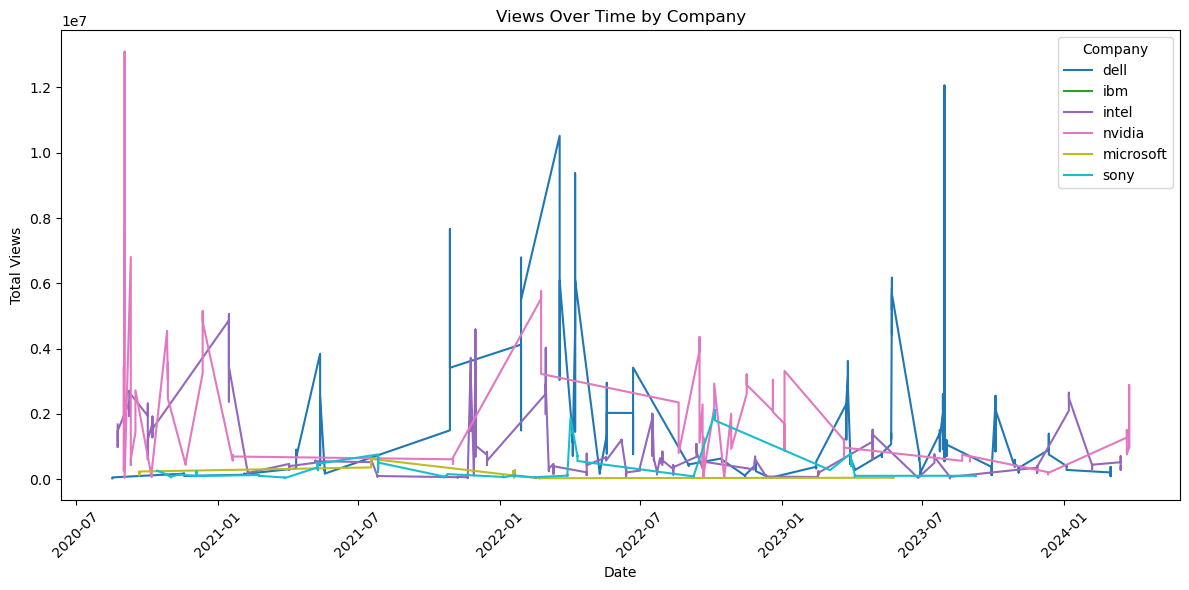

In [128]:
import matplotlib.pyplot as plt
from pyspark.sql.functions import col, to_date, sum as spark_sum

# Convert publishedAt to a date format and aggregate view_count by date and company
df_views_over_time = df_transformed.withColumn("published_date", to_date(col("publishedAt"))).groupBy(
    "published_date", "company", "title", "view_count"
).agg(
    spark_sum("view_count").alias("total_views")
).orderBy("published_date")

colors = plt.cm.get_cmap('tab10', len(companies))

plot_data_yt = df_views_over_time.toPandas() 

# Plot views over time for each company
plt.figure(figsize=(12, 6))

companies = plot_data_yt["company"].unique()
for i, company in enumerate(companies):
    company_data = plot_data_yt[plot_data_yt["company"] == company]
    plt.plot(
        company_data["published_date"],
        company_data["total_views"],
        label=company,
        color=colors(i)
    )

plt.title("Views Over Time by Company")
plt.xlabel("Date")
plt.ylabel("Total Views")
plt.legend(title="Company")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [129]:
plot_data_yt = df_views_over_time.toPandas() 

In [130]:
# df_combined = df_companies.join(
#     df_yt,
#     df_companies["company_name"] == df_yt["company"],
#     how="inner"
# ).select("Date", "Adj Close", "company_name", "likes", "view_count")

# df_combined

In [131]:
plot_data_companies = df_companies.toPandas()

/tmp/ipykernel_15266/2039972490.py:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab10', len(companies))


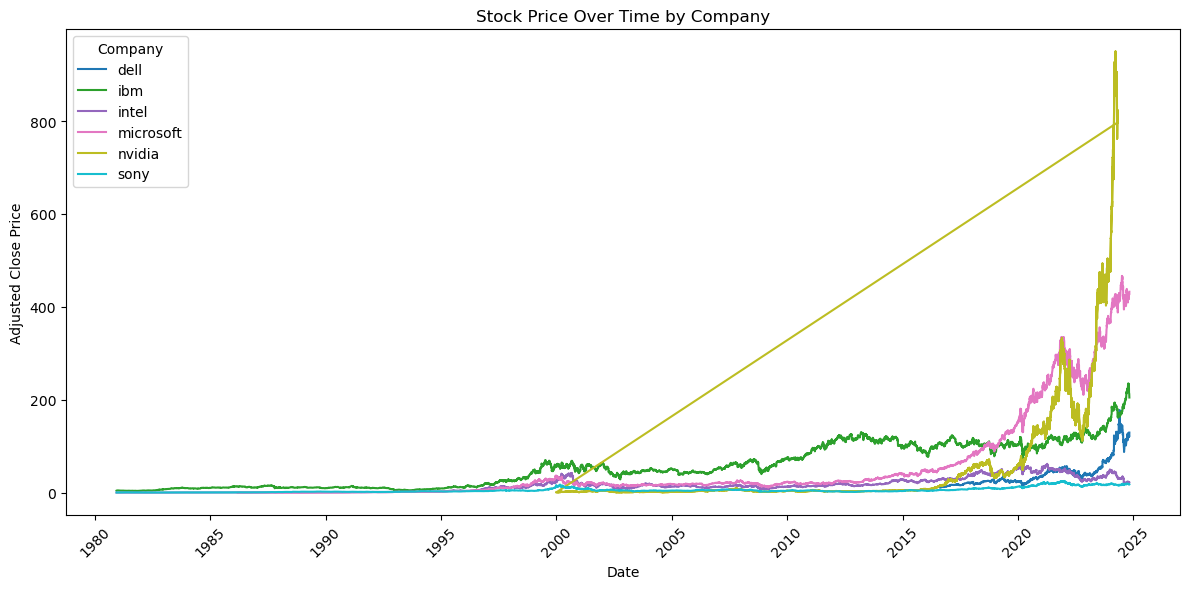

In [132]:
plt.figure(figsize=(12, 6))

companies = plot_data_companies["company_name"].unique()
colors = plt.cm.get_cmap('tab10', len(companies))

for i, company in enumerate(companies):
    company_data = plot_data_companies[plot_data_companies["company_name"] == company]
    plt.plot(company_data["Date"], company_data["Adj Close"], label=company, color=colors(i))

plt.title("Stock Price Over Time by Company")
plt.xlabel("Date")
plt.ylabel("Adjusted Close Price")
plt.legend(title="Company")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# AQUELA LINHA DA NVIDIA, QUE DEVIA CONTINUAR PARA A FRENTE (COMO AS OUTRAS) MANDOU O FODA SE AHHAHAHAAHA

/tmp/ipykernel_15266/2024041847.py:8: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab10', len(companies))


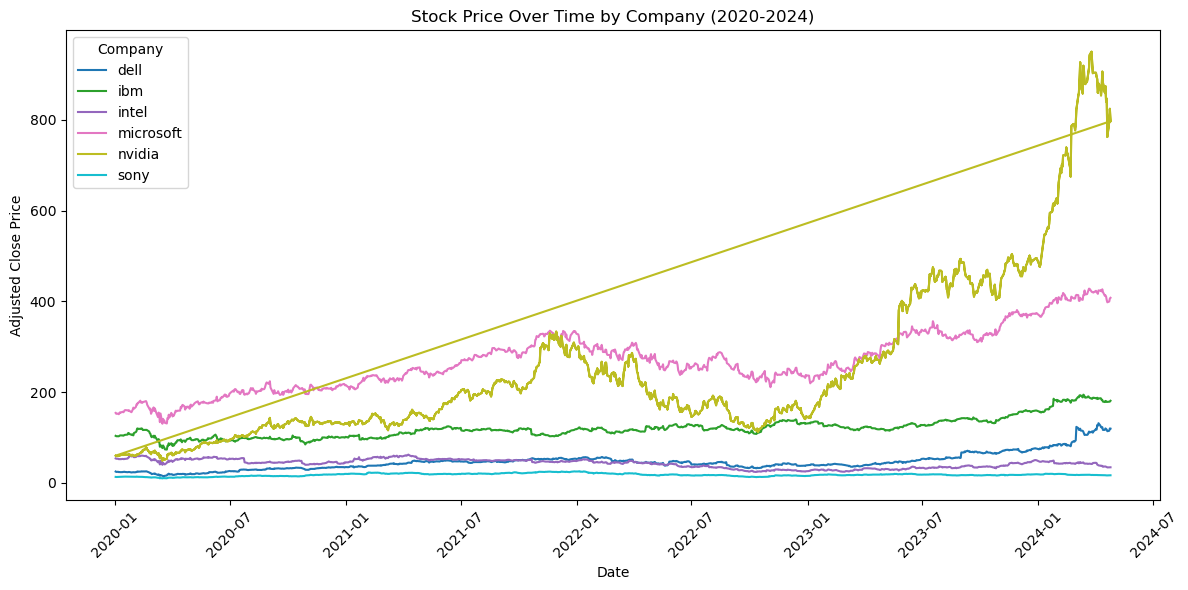

In [133]:
plot_data_filtered = df_companies.filter(
    (col("Date") >= "2020-01-01") & (col("Date") <= "2024-04-24")
)

plot_data_companies = plot_data_filtered.toPandas()
plt.figure(figsize=(12, 6))
companies = plot_data_companies["company_name"].unique()
colors = plt.cm.get_cmap('tab10', len(companies))

for i, company in enumerate(companies):
    company_data = plot_data_companies[plot_data_companies["company_name"] == company]
    plt.plot(company_data["Date"], company_data["Adj Close"], label=company, color=colors(i))

plt.title("Stock Price Over Time by Company (2020-2024)")
plt.xlabel("Date")
plt.ylabel("Adjusted Close Price")
plt.legend(title="Company")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [134]:
plot_data_yt = plot_data_yt[
    (plot_data_yt["company"] != "sony") &
    (plot_data_yt["company"] != "dell") &
    (plot_data_yt["company"] != "ibm") &
    (plot_data_yt["company"] != "intel")
]


In [135]:
plot_data_yt

,published_date,company,title,view_count,total_views
11,2020-09-01,nvidia,"NVIDIA RTX 3090, 3080, 3070 Specs, Cooler, Pri...",575855,1727565
12,2020-09-01,nvidia,NVIDIA GeForce RTX 30 Series | Official Launch...,1101692,3305076
13,2020-09-01,nvidia,"NVIDIA RTX 3090, 3080, 3070 Specs, Cooler, Pri...",399493,1198479
14,2020-09-01,nvidia,NVIDIA GeForce RTX 30 Series | Official Launch...,736827,2210481
15,2020-09-01,nvidia,"ITS HERE - NVIDIA RTX 3090, RTX 3080 and RTX 3...",309933,929799
...,...,...,...,...,...
929,2024-03-25,nvidia,"The Race For AI Robots Just Got Real (OpenAI, ...",925995,2777985
930,2024-03-25,nvidia,"The Race For AI Robots Just Got Real (OpenAI, ...",841972,2525916
931,2024-03-25,nvidia,"The Race For AI Robots Just Got Real (OpenAI, ...",783300,2349900
932,2024-03-25,nvidia,"The Race For AI Robots Just Got Real (OpenAI, ...",975782,975782


In [136]:
plot_data_companies = plot_data_companies[
    (plot_data_companies["company_name"] != "sony") &
    (plot_data_companies["company_name"] != "dell") &
    (plot_data_companies["company_name"] != "ibm") &
    (plot_data_companies["company_name"] != "intel")
]

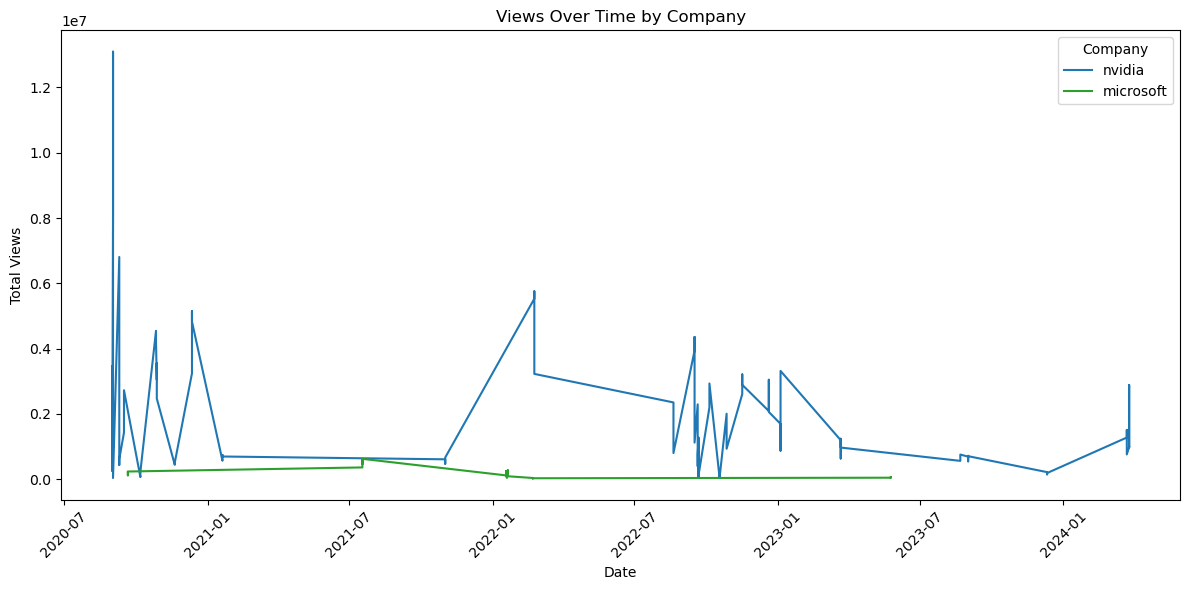

In [137]:
# Plot views over time for each company
plt.figure(figsize=(12, 6))

companies = plot_data_yt["company"].unique()
for i, company in enumerate(companies):
    company_data = plot_data_yt[plot_data_yt["company"] == company]
    plt.plot(
        company_data["published_date"],
        company_data["total_views"],
        label=company,
        color=colors(i)
    )

plt.title("Views Over Time by Company")
plt.xlabel("Date")
plt.ylabel("Total Views")
plt.legend(title="Company")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

/tmp/ipykernel_15266/1399521977.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab10', len(companies))


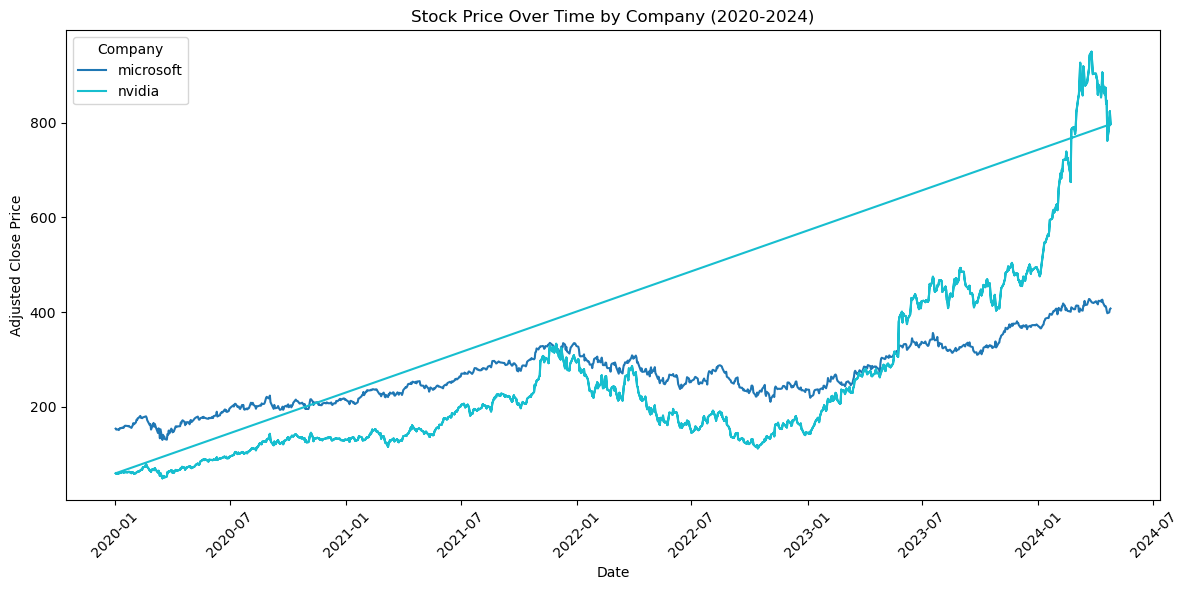

In [138]:
plt.figure(figsize=(12, 6))
companies = plot_data_companies["company_name"].unique()
colors = plt.cm.get_cmap('tab10', len(companies))

for i, company in enumerate(companies):
    company_data = plot_data_companies[plot_data_companies["company_name"] == company]
    plt.plot(company_data["Date"], company_data["Adj Close"], label=company, color=colors(i))

plt.title("Stock Price Over Time by Company (2020-2024)")
plt.xlabel("Date")
plt.ylabel("Adjusted Close Price")
plt.legend(title="Company")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


/tmp/ipykernel_15266/2078771881.py:15: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors_views = plt.cm.get_cmap('copper', len(plot_data_yt["company"].unique()))
/tmp/ipykernel_15266/2078771881.py:16: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors_stocks = plt.cm.get_cmap('Set2', len(plot_data_companies["company_name"].unique()))


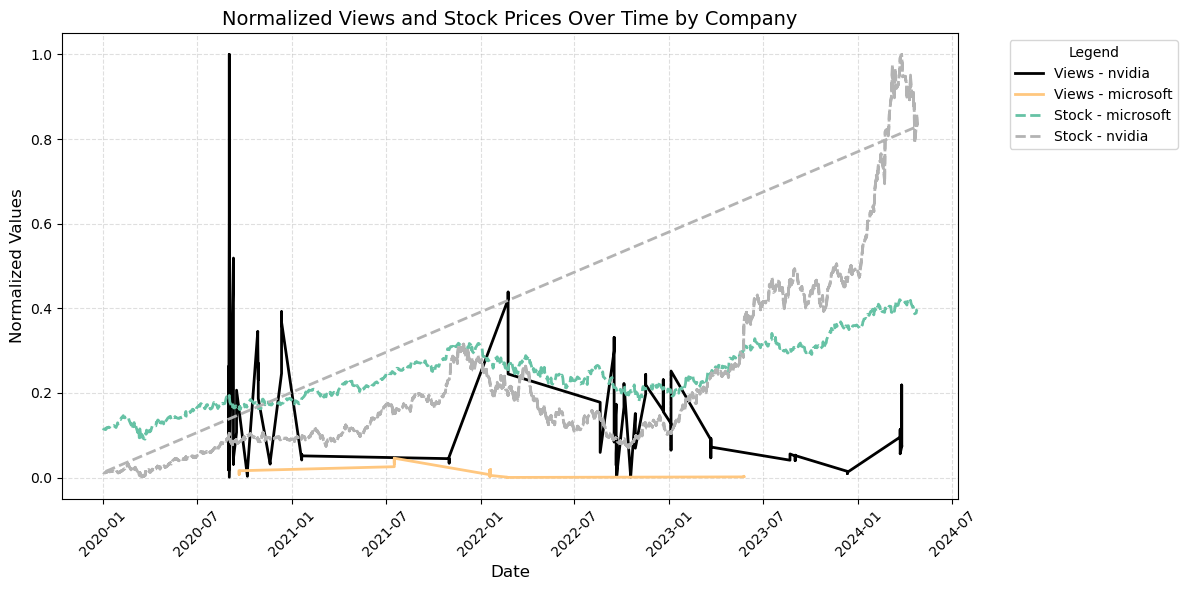

In [139]:
import matplotlib.pyplot as plt
import numpy as np

# Normalização Min-Max
def normalize(series):
    return (series - series.min()) / (series.max() - series.min())

# Normalizar as views
plot_data_yt["normalized_views"] = normalize(plot_data_yt["total_views"])

# Normalizar os preços de ações
plot_data_companies["normalized_stocks"] = normalize(plot_data_companies["Adj Close"])

# Paletas de cores
colors_views = plt.cm.get_cmap('copper', len(plot_data_yt["company"].unique()))
colors_stocks = plt.cm.get_cmap('Set2', len(plot_data_companies["company_name"].unique()))

# Criar a figura
plt.figure(figsize=(12, 6))

# Plot das views normalizadas
for i, company in enumerate(plot_data_yt["company"].unique()):
    company_data = plot_data_yt[plot_data_yt["company"] == company]
    plt.plot(
        company_data["published_date"],
        company_data["normalized_views"],
        label=f"Views - {company}",
        color=colors_views(i),
        
        linestyle='-',
        linewidth=2
    )

# Plot dos preços normalizados
for i, company in enumerate(plot_data_companies["company_name"].unique()):
    company_data = plot_data_companies[plot_data_companies["company_name"] == company]
    plt.plot(
        company_data["Date"],
        company_data["normalized_stocks"],
        label=f"Stock - {company}",
        color=colors_stocks(i),
        linestyle='--',
        linewidth=2
    )

# Configurações do gráfico
plt.title("Normalized Views and Stock Prices Over Time by Company", fontsize=14)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Normalized Values", fontsize=12)
plt.legend(title="Legend", loc='upper left', bbox_to_anchor=(1.05, 1), fontsize=10)
plt.xticks(rotation=45, fontsize=10)
plt.tight_layout()
plt.grid(alpha=0.4, linestyle='--')
plt.show()




In [140]:
# Top 5 vídeos da Microsoft
top_5_microsoft = plot_data_yt[plot_data_yt["company"] == "microsoft"].nlargest(5, "view_count")

# Top 5 vídeos da NVIDIA
top_5_nvidia = plot_data_yt[plot_data_yt["company"] == "nvidia"].nlargest(5, "view_count")

# Exibir os resultados
print("Top 5 vídeos da Microsoft:")
print(top_5_microsoft[["title", "view_count", "published_date"]])

print("\nTop 5 vídeos da NVIDIA:")
print(top_5_nvidia[["title", "view_count", "published_date"]])


Top 5 vídeos da Microsoft:
                                                 title  view_count  \
205  La CAIDA de BILL GATES y El GRAN JUICIO contra...      625556   
201  La CAIDA de BILL GATES y El GRAN JUICIO contra...      605170   
202  La CAIDA de BILL GATES y El GRAN JUICIO contra...      578623   
200  La CAIDA de BILL GATES y El GRAN JUICIO contra...      546446   
203  La CAIDA de BILL GATES y El GRAN JUICIO contra...      511401   

    published_date  
205     2021-07-18  
201     2021-07-18  
202     2021-07-18  
200     2021-07-18  
203     2021-07-18  

Top 5 vídeos da NVIDIA:
                                         title  view_count published_date
34  NVIDIA just made EVERYTHING ELSE obsolete.     4480947     2020-09-02
35  NVIDIA just made EVERYTHING ELSE obsolete.     4365315     2020-09-02
33  NVIDIA just made EVERYTHING ELSE obsolete.     4222370     2020-09-02
31  NVIDIA just made EVERYTHING ELSE obsolete.     4039802     2020-09-02
37  NVIDIA just made EVERYTHING

In [141]:
----

SyntaxError: invalid syntax (2133496677.py, line 1)

In [ ]:
z = plot_data_companies['Adj Close']
x = plot_data_companies['Date']
y = plot_data_companies['Volume']
x, y = np.meshgrid(x, y)

region = np.s_[5:50, 5:50]
x, y, z = x[region], y[region], z[region]

# Set up plot
fig, ax = plt.subplots(subplot_kw=dict(projection='3d'))

ls = LightSource(270, 45)
# To use a custom hillshading mode, override the built-in shading and pass
# in the rgb colors of the shaded surface calculated from "shade".
rgb = ls.shade(z, cmap=cm.gist_earth, vert_exag=0.1, blend_mode='soft')
surf = ax.plot_surface(x, y, z, rstride=1, cstride=1, facecolors=rgb,
                       linewidth=0, antialiased=False, shade=False)

plt.show()